In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt

In [ ]:
torch.__version__

'1.4.0'

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Load shuffled audio files converted into MEL-Spectorgrams - TRAIN
npzfile = np.load('/content/drive/My Drive/audiodataset/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print("X_train.shape: ", X_train.shape, "y_train.shape: ", y_train.shape)

['arr_0', 'arr_1']
X_train.shape:  (6394, 640, 128) y_train.shape:  (6394, 8)


In [ ]:
# Load shuffled audio files converted into MEL-Spectorgrams - VALID
npzfile = np.load('/content/drive/My Drive/audiodataset/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print("X_valid.shape: ", X_valid.shape, "y_valid.shape: ", y_valid.shape)

['arr_0', 'arr_1']
X_valid.shape:  (800, 640, 128) y_valid.shape:  (800, 8)


In [ ]:
# Load audio files converted into MEL-Spectorgrams - TEST
npzfile = np.load('/content/drive/My Drive/audiodataset/test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
y_test -= 1 # Labels are one-indexed, switch to zero-index
print("X_test.shape: ", X_test.shape, "y_test.shape: ", y_test.shape)

['arr_0', 'arr_1']
X_test.shape:  (800, 640, 128) y_test.shape:  (800,)


In [ ]:
# Creating a dataloader for trainning data
tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train)
tensor_x_train = torch.unsqueeze(tensor_x_train, 1)
print("tensor_x_train.shape: ", tensor_x_train.shape)

train_set = data.TensorDataset(tensor_x_train,tensor_y_train)
train_dataloader = data.DataLoader(train_set,batch_size=32, shuffle=True)

# Creating a dataloader for validation data
tensor_x_valid = torch.Tensor(X_valid)
tensor_y_valid = torch.Tensor(y_valid)
tensor_x_valid = torch.unsqueeze(tensor_x_valid, 1)
print("tensor_x_valid.shape: ", tensor_x_valid.shape)

valid_set = data.TensorDataset(tensor_x_valid, tensor_y_valid)
valid_dataloader = data.DataLoader(valid_set, batch_size=32, shuffle=False)

# Creating a dataloader for test data
tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test)
tensor_x_test = torch.unsqueeze(tensor_x_test, 1)
print("tensor_x_test.shape: ", tensor_x_test.shape)
test_set = data.TensorDataset(tensor_x_test, tensor_y_test)
test_dataloader = data.DataLoader(test_set, batch_size=32, shuffle=False)

tensor_x_train.shape:  torch.Size([6394, 1, 640, 128])
tensor_x_valid.shape:  torch.Size([800, 1, 640, 128])
tensor_x_test.shape:  torch.Size([800, 1, 640, 128])


In [ ]:
def plot_accuracies(train_accuracy_per_epoch, valid_accuracy_per_epoch, epochs, model_name):
  plt.figure(figsize=(10,6))
  plt.plot(range(1, epochs + 1), train_accuracy_per_epoch, 'b', label='Train Accuracy per epoch')
  plt.plot(range(1, epochs + 1), valid_accuracy_per_epoch, 'r', label='Validation Accuracy per epoch')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.title(model_name + " Accuracy")
  plt.show()

def plot_loss(train_loss_per_epoch, valid_loss_per_epoch, epochs, model_name):
  plt.figure(figsize=(10,6))
  plt.plot(range(1, epochs + 1), train_loss_per_epoch, 'b', label='Train Loss per epoch')
  plt.plot(range(1, epochs + 1), valid_loss_per_epoch, 'r', label='Validation Loss per epoch')
  plt.xlabel("Number of Epochs")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.title(model_name + " Loss")
  plt.show()

In [ ]:
def calc_validation_accuracy(net):
  with torch.no_grad():
    correct = 0 
    for i, data in enumerate(valid_dataloader, 0):
      inputs, labels = data      
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      outputs = net(inputs)
      labels = torch.max(labels, 1)[1]
      indices_max = torch.max(outputs, 1)[1]
      correct += (indices_max == labels).sum().item()

    accuracy = 100 * correct / len(valid_dataloader.dataset)
  return accuracy

In [ ]:
def calc_test_accuracy(net):
  with torch.no_grad():
    correct = 0 
    for i, data in enumerate(test_dataloader, 0):
      inputs, labels = data      
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      outputs = net(inputs)
      indices_max = torch.max(outputs, 1)[1]
      correct += (indices_max == labels).sum().item()

    accuracy = 100 * correct / len(test_dataloader.dataset)
  return accuracy

In [ ]:
def calc_validation_loss(net, criterion):
  with torch.no_grad():
    loss = 0.0
    for inputs, labels in valid_dataloader:
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU
      outputs = net(inputs)
      labels = torch.max(labels, 1)[1]
      loss += criterion(outputs, labels).item()
    return loss/len(valid_dataloader)

In [ ]:
# training loop

def train(net, train_dataloader, epochs, optim):
  # define loss function, optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim
  
  train_accuracy_per_epoch = []
  valid_accuracy_per_epoch = []
  train_loss_per_epoch = []
  valid_loss_per_epoch = []

  for epoch in range(epochs):
    correct = 0
    running_loss = 0.0
    epoch_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
      # get the inputs
      inputs, labels = data
      
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      labels = torch.max(labels, 1)[1]
      loss = criterion(outputs,  labels)
      loss.backward()
      optimizer.step()

      # accuracy and loss maintaining
      running_loss += loss.item()
      epoch_loss += loss.item()
      indices_max = torch.max(outputs, 1)[1]
      correct += (indices_max == labels).sum().item()
    

    valid_loss = calc_validation_loss(net, criterion)
    train_loss = epoch_loss / len(train_dataloader)
    valid_loss_per_epoch.append(valid_loss)
    train_loss_per_epoch.append(train_loss)
    
    train_accuracy = 100 * correct / len(X_train)
    train_accuracy_per_epoch.append(train_accuracy)
    valid_accuracy = calc_validation_accuracy(net)
    valid_accuracy_per_epoch.append(valid_accuracy)

    print("Epoch #", epoch)
    print("Train Accuracy = {}".format(train_accuracy))
    print("Valid Accuracy = {}".format(valid_accuracy))
    print("Train Loss = {}".format(train_loss))
    print("Valid Loss = {}".format(valid_loss))

  print('Finished Training')
  return train_accuracy_per_epoch, valid_accuracy_per_epoch, train_loss_per_epoch, valid_loss_per_epoch

In [ ]:
class CRNN(nn.Module):
  def __init__(self):
      super(CRNN, self).__init__()
      
      self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1 = nn.BatchNorm1d(32, momentum = 0.9)
      self.drop1  = nn.Dropout(0.5)

      self.conv2 = nn.Conv1d(in_channels=32, out_channels=40, kernel_size=5)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2 = nn.BatchNorm1d(40, momentum = 0.9)
      self.drop2  = nn.Dropout(0.5)

      self.conv3 = nn.Conv1d(in_channels=40, out_channels=52, kernel_size=5)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3 = nn.BatchNorm1d(52, momentum = 0.9)
      self.drop3  = nn.Dropout(0.5)

      self.rnn = nn.LSTM(10236, 96, 1)
      self.drop4  = nn.Dropout(0.5)

      self.fc1    = nn.Linear(in_features=4992, out_features=64)
      self.drop5  = nn.Dropout(0.5)
      self.fc2    = nn.Linear(in_features=64,  out_features=8)

  def forward(self, x):
      x = x.view(-1,1, self.num_flat_features(x)) # keep channel dimension '1' for conv, flatten images

      # 3 CNN
      x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
      x   = self.drop1(x)
      x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
      x   = self.drop2(x)
      x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
      x   = self.drop3(x)

      # LSTM
      x, (hn,cn) = self.rnn(x)
      x = self.drop4(x)

      # fully connected
      x = x.view(-1,self.num_flat_features(x))
      x = self.fc1(x)
      x   = self.drop5(x)
      x = self.fc2(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


In [ ]:
class CRNN_stacked(nn.Module):
  def __init__(self):
      super(CRNN_stacked, self).__init__()
      
      self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1 = nn.BatchNorm1d(32)
      self.drop1  = nn.Dropout(0.3)

      self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2 = nn.BatchNorm1d(32)

      self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3 = nn.BatchNorm1d(32)

      self.conv4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
      torch.nn.init.xavier_uniform_(self.conv4.weight)
      self.bn4 = nn.BatchNorm1d(32)

      self.conv5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
      torch.nn.init.xavier_uniform_(self.conv5.weight)
      self.bn5 = nn.BatchNorm1d(32)

      self.rnn = nn.LSTM(2560, 96, 2)
      self.drop2  = nn.Dropout(0.5)
      self.fc1    = nn.Linear(in_features=3072, out_features=512)
      self.drop3  = nn.Dropout(0.5)

      self.fc2 = nn.Linear(in_features=512, out_features=64)
      self.drop8  = nn.Dropout(0.5)

      self.fc3    = nn.Linear(in_features=64,  out_features=8)

  def forward(self, x):
      x = x.view(-1,1, self.num_flat_features(x)) # keep channel dimension '1' for conv, flatten images

      # 5 CNN
      x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
      x   = self.drop1(x)
      x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
      x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
      x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
      x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 2)

      # LSTM
      x, (hn,cn) = self.rnn(x)
      x = self.drop2(x)

      # fully connected
      x = x.view(-1,self.num_flat_features(x))
      x = self.fc1(x)
      x   = self.drop3(x)
      x = self.fc2(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [ ]:
class RNN(nn.Module):
  def __init__(self):
      super(RNN, self).__init__()
      self.rnn = nn.LSTM(81920, 96, 1)
      self.drop1  = nn.Dropout(0.5)

      self.fc1    = nn.Linear(in_features=96, out_features=64)
      self.drop2  = nn.Dropout(0.5)
      self.fc2    = nn.Linear(in_features=64,  out_features=8)

  def forward(self, x):
      x = x.view(-1,1, self.num_flat_features(x)) # keep channel dimension '1' for lstm, flatten images
      # LSTM
      x, (hn,cn) = self.rnn(x)
      x = self.drop1(x)

      # fully connected
      x = x.view(-1,self.num_flat_features(x))
      x = self.fc1(x)
      x   = self.drop2(x)
      x = self.fc2(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [ ]:
class CNN_1D_Shallow(nn.Module):
  def __init__(self):
      super(CNN_1D_Shallow, self).__init__()

      self.conv1  = nn.Conv1d(in_channels=1,     out_channels=8,    kernel_size=3,  stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1    = nn.BatchNorm1d(8)

      self.conv2  = nn.Conv1d(in_channels=8, out_channels=16,      kernel_size=3,  stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2    = nn.BatchNorm1d(16)

      self.conv3  = nn.Conv1d(in_channels=16, out_channels=64,      kernel_size=3,  stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3    = nn.BatchNorm1d(64)

      self.conv4  = nn.Conv1d(in_channels=64, out_channels=128,      kernel_size=3,  stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv4.weight)
      self.bn4    = nn.BatchNorm1d(128)

      self.fc1    = nn.Linear(in_features=40960,  out_features=1024)
      self.drop1  = nn.Dropout(0.5)

      self.fc2    = nn.Linear(in_features=1024,  out_features=256)
      self.drop2  = nn.Dropout(0.5)

      self.fc3    = nn.Linear(in_features=256,   out_features=8)

  def forward(self, x):
      x = x.view(-1,1, self.num_flat_features(x)) # keep channel dimension '1' for conv, flatten images
      x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
      x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
      x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
      x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x   = self.drop1(x)
      x = F.relu(self.fc2(x))
      x   = self.drop2(x)
      x = self.fc3(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [ ]:
class CNN_1D_Deep(nn.Module):
  def __init__(self):
      super(CNN_1D_Deep, self).__init__()
      
      self.conv1  = nn.Conv1d(in_channels=1,     out_channels=32,    kernel_size=3, stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1    = nn.BatchNorm1d(32)

      self.conv2  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3,stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2    = nn.BatchNorm1d(32)

      self.conv3  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2,   padding=1)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3    = nn.BatchNorm1d(32)

      self.conv4  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2,  padding=1)
      torch.nn.init.xavier_uniform_(self.conv4.weight)
      self.bn4    = nn.BatchNorm1d(32)

      self.conv5  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2,   padding=1)
      torch.nn.init.xavier_uniform_(self.conv5.weight)
      self.bn5    = nn.BatchNorm1d(32)

      self.conv6  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2,   padding=1)
      torch.nn.init.xavier_uniform_(self.conv6.weight)
      self.bn6    = nn.BatchNorm1d(32)

      self.conv7  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3,stride=2,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv7.weight)
      self.bn7    = nn.BatchNorm1d(32)

      self.conv8  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2,  padding=1)
      torch.nn.init.xavier_uniform_(self.conv8.weight)
      self.bn8    = nn.BatchNorm1d(32)

      self.conv9  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3,  stride=2,  padding=1)
      torch.nn.init.xavier_uniform_(self.conv9.weight)
      self.bn9    = nn.BatchNorm1d(32)

      self.conv10  = nn.Conv1d(in_channels=32, out_channels=32,      kernel_size=3, stride=2, padding=1)
      torch.nn.init.xavier_uniform_(self.conv10.weight)
      self.bn10    = nn.BatchNorm1d(32)

      self.fc1    = nn.Linear(in_features=160,  out_features=1024)
      self.drop1  = nn.Dropout(0.5)

      self.fc2    = nn.Linear(in_features=1024,  out_features=256)
      self.drop2  = nn.Dropout(0.5)

      self.fc3    = nn.Linear(in_features=256,   out_features=8)

  def forward(self, x):
      x = x.view(-1,1, self.num_flat_features(x)) # keep channel dimension '1' for conv, flatten images
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
      x = F.relu(self.bn4(self.conv4(x)))
      x = F.relu(self.bn5(self.conv5(x)))
      x = F.max_pool1d(F.relu(self.bn6(self.conv6(x))), 2)
      x = F.relu(self.bn7(self.conv7(x)))
      x = F.relu(self.bn8(self.conv8(x)))
      x = F.max_pool1d(F.relu(self.bn9(self.conv9(x))), 2)
      x = F.max_pool1d(F.relu(self.bn10(self.conv10(x))), 2)

      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.drop1(x)
      x = F.relu(self.fc2(x))
      x = self.drop2(x)
      x = self.fc3(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [ ]:
class CNN_2D_Shallow(nn.Module):
  def __init__(self):
      super(CNN_2D_Shallow, self).__init__()
      
      self.conv1  = nn.Conv2d(in_channels=1,     out_channels=8,    kernel_size=3,  stride=[2,1],   padding=1)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1    = nn.BatchNorm2d(8)

      self.conv2  = nn.Conv2d(in_channels=8, out_channels=16,      kernel_size=3,  stride=[2,1],   padding=1)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2    = nn.BatchNorm2d(16)

      self.conv3  = nn.Conv2d(in_channels=16, out_channels=64,      kernel_size=3,  stride=[2,1],   padding=1)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3    = nn.BatchNorm2d(64)

      self.conv4  = nn.Conv2d(in_channels=64, out_channels=128,      kernel_size=3,  stride=[2,1],   padding=1)
      torch.nn.init.xavier_uniform_(self.conv4.weight)
      self.bn4    = nn.BatchNorm2d(128)

      self.fc1    = nn.Linear(in_features=2048,  out_features=1024)
      self.drop1  = nn.Dropout(0.5)

      self.fc2    = nn.Linear(in_features=1024,  out_features=256)
      self.drop2  = nn.Dropout(0.5)

      self.fc3    = nn.Linear(in_features=256,   out_features=8)

  def forward(self, x):
      x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
      x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
      x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
      x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), 2)
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.drop1(x)
      x = F.relu(self.fc2(x))
      x = self.drop2(x)
      x = self.fc3(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [ ]:
class CNN_2D_Deep(nn.Module):
  def __init__(self):
      super(CNN_2D_Deep, self).__init__()
      
      self.conv1  = nn.Conv2d(in_channels=1,     out_channels=32,    kernel_size=3,  stride=[2,1],   padding=1)
      torch.nn.init.xavier_uniform_(self.conv1.weight)
      self.bn1    = nn.BatchNorm2d(32)

      self.conv2  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3, stride=[2,1], padding=1)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      self.bn2    = nn.BatchNorm2d(32)

      self.conv3  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      self.bn3    = nn.BatchNorm2d(32)

      self.conv4  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,   padding=1)
      torch.nn.init.xavier_uniform_(self.conv4.weight)
      self.bn4    = nn.BatchNorm2d(32)

      self.conv5  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv5.weight)
      self.bn5    = nn.BatchNorm2d(32)

      self.conv6  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv6.weight)
      self.bn6    = nn.BatchNorm2d(32)

      self.conv7  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv7.weight)
      self.bn7    = nn.BatchNorm2d(32)

      self.conv8  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,   padding=1)
      torch.nn.init.xavier_uniform_(self.conv8.weight)
      self.bn8    = nn.BatchNorm2d(32)

      self.conv9  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,    padding=1)
      torch.nn.init.xavier_uniform_(self.conv9.weight)
      self.bn9    = nn.BatchNorm2d(32)

      self.conv10  = nn.Conv2d(in_channels=32, out_channels=32,      kernel_size=3,  padding=1)
      torch.nn.init.xavier_uniform_(self.conv10.weight)
      self.bn10    = nn.BatchNorm2d(32)

      self.fc1    = nn.Linear(in_features=2560,  out_features=1024)
      self.drop1  = nn.Dropout(0.5)

      self.fc2    = nn.Linear(in_features=1024,  out_features=256)
      self.drop2  = nn.Dropout(0.5)

      self.fc3    = nn.Linear(in_features=256,   out_features=8)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
      x = F.relu(self.bn4(self.conv4(x)))
      x = F.relu(self.bn5(self.conv5(x)))
      x = F.max_pool2d(F.relu(self.bn6(self.conv6(x))), 2)
      x = F.relu(self.bn7(self.conv7(x)))
      x = F.relu(self.bn8(self.conv8(x)))
      x = F.max_pool2d(F.relu(self.bn9(self.conv9(x))), 2)
      x = F.max_pool2d(F.relu(self.bn10(self.conv10(x))), 2)
      x = x.view(-1, self.num_flat_features(x))
      x = F.relu(self.fc1(x))
      x = self.drop1(x)
      x = F.relu(self.fc2(x))
      x = self.drop2(x)
      x = self.fc3(x)
      return x

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

Epoch # 0
Train Accuracy = 21.05098529871755
Valid Accuracy = 26.875
Train Loss = 1.9952952533960342
Valid Loss = 1.8201413440704346
Epoch # 1
Train Accuracy = 32.71817328745699
Valid Accuracy = 39.625
Train Loss = 1.7782627195119858
Valid Loss = 1.6930090522766112
Epoch # 2
Train Accuracy = 36.518611197998126
Valid Accuracy = 38.125
Train Loss = 1.6915639299154281
Valid Loss = 1.7543040895462036
Epoch # 3
Train Accuracy = 38.17641538942759
Valid Accuracy = 35.25
Train Loss = 1.6583441281318665
Valid Loss = 1.7066899156570434
Epoch # 4
Train Accuracy = 40.897716609321236
Valid Accuracy = 39.0
Train Loss = 1.612891286611557
Valid Loss = 1.6312387371063233
Epoch # 5
Train Accuracy = 42.05505161088521
Valid Accuracy = 46.375
Train Loss = 1.5941806799173355
Valid Loss = 1.5379016304016113
Epoch # 6
Train Accuracy = 43.29058492336566
Valid Accuracy = 43.375
Train Loss = 1.58240338742733
Valid Loss = 1.6099552726745605
Epoch # 7
Train Accuracy = 43.994369721614014
Valid Accuracy = 43.875
Tra

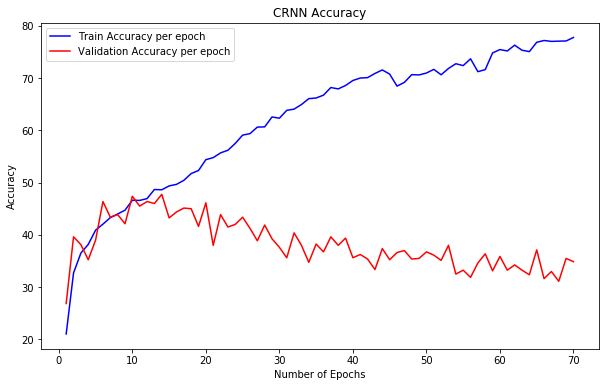

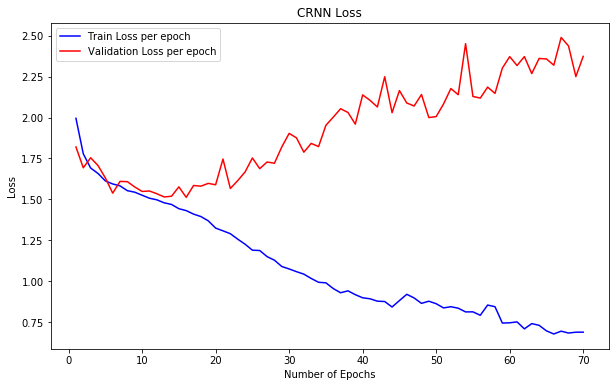

Test accuracy:  27.125


In [ ]:
epochs = 70
net_crnn = CRNN().cuda()
optimizer = torch.optim.Adam(net_crnn.parameters(),weight_decay=0.01)
train_accuracy_crnn, valid_accuracy_crnn, train_loss_crnn, valid_loss_crnn = train(net_crnn,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_crnn,valid_accuracy_crnn,epochs,"CRNN")
plot_loss(train_loss_crnn, valid_loss_crnn, epochs, "CRNN")
test_accuracy_crnn = calc_test_accuracy(net_crnn)
print("Test accuracy: ", test_accuracy_crnn)

Epoch # 0
Train Accuracy = 25.383171723490772
Valid Accuracy = 35.125
Train Loss = 1.9880328530073166
Valid Loss = 1.7935513591766357
Epoch # 1
Train Accuracy = 38.6143259305599
Valid Accuracy = 36.625
Train Loss = 1.6871531665325166
Valid Loss = 1.787045111656189
Epoch # 2
Train Accuracy = 40.710040663121674
Valid Accuracy = 41.125
Train Loss = 1.649209185242653
Valid Loss = 1.6122266244888306
Epoch # 3
Train Accuracy = 42.74319674695027
Valid Accuracy = 42.5
Train Loss = 1.6112798088788987
Valid Loss = 1.5618028688430785
Epoch # 4
Train Accuracy = 44.27588364091336
Valid Accuracy = 42.25
Train Loss = 1.5676328653097154
Valid Loss = 1.551754403114319
Epoch # 5
Train Accuracy = 46.449796684391615
Valid Accuracy = 48.75
Train Loss = 1.5544339889287948
Valid Loss = 1.4817856645584107
Epoch # 6
Train Accuracy = 47.857366280888336
Valid Accuracy = 45.625
Train Loss = 1.5134899759292602
Valid Loss = 1.5405667781829835
Epoch # 7
Train Accuracy = 48.013762902721304
Valid Accuracy = 47.125
Tra

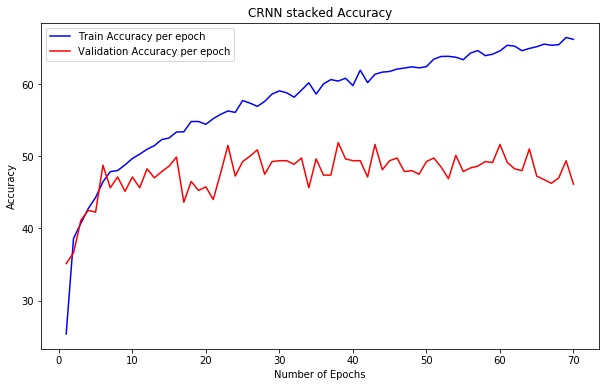

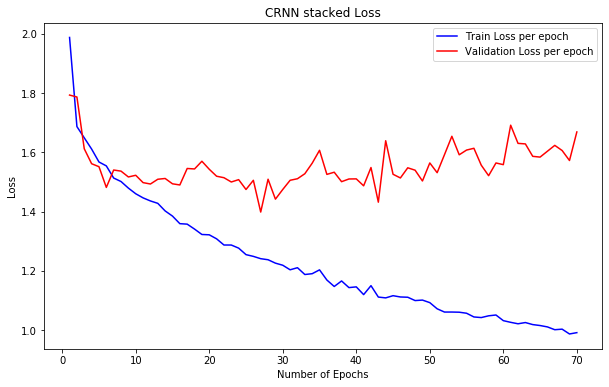

Test accuracy:  40.125


In [ ]:
epochs = 70
net_crnn_stacked = CRNN_stacked().cuda()
optimizer = torch.optim.Adam(net_crnn_stacked.parameters(),weight_decay=0.01)
train_accuracy_crnn_stacked, valid_accuracy_crnn_stacked, train_loss_crnn_stacked, valid_loss_crnn_stacked = train(net_crnn_stacked,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_crnn_stacked,valid_accuracy_crnn_stacked,epochs,"CRNN stacked")
plot_loss(train_loss_crnn_stacked, valid_loss_crnn_stacked, epochs, "CRNN stacked")
test_accuracy_crnn_stacked = calc_test_accuracy(net_crnn_stacked)
print("Test accuracy: ", test_accuracy_crnn_stacked)

Epoch # 0
Train Accuracy = 12.777604003753519
Valid Accuracy = 11.75
Train Loss = 2.098012029528618
Valid Loss = 2.081027250289917
Epoch # 1
Train Accuracy = 12.66812636847044
Valid Accuracy = 11.75
Train Loss = 2.086566331386566
Valid Loss = 2.089074192047119
Epoch # 2
Train Accuracy = 12.746324679386925
Valid Accuracy = 10.5
Train Loss = 2.084738301038742
Valid Loss = 2.0830338859558104
Epoch # 3
Train Accuracy = 12.449171097904285
Valid Accuracy = 14.875
Train Loss = 2.0835785055160523
Valid Loss = 2.0844626522064207
Epoch # 4
Train Accuracy = 12.730685017203628
Valid Accuracy = 11.75
Train Loss = 2.082304697036743
Valid Loss = 2.079803638458252
Epoch # 5
Train Accuracy = 12.699405692837034
Valid Accuracy = 13.75
Train Loss = 2.080368685722351
Valid Loss = 2.079638662338257
Epoch # 6
Train Accuracy = 13.027838598686268
Valid Accuracy = 13.0
Train Loss = 2.0807734656333925
Valid Loss = 2.0795178413391113
Epoch # 7
Train Accuracy = 12.8714419768533
Valid Accuracy = 12.875
Train Loss =

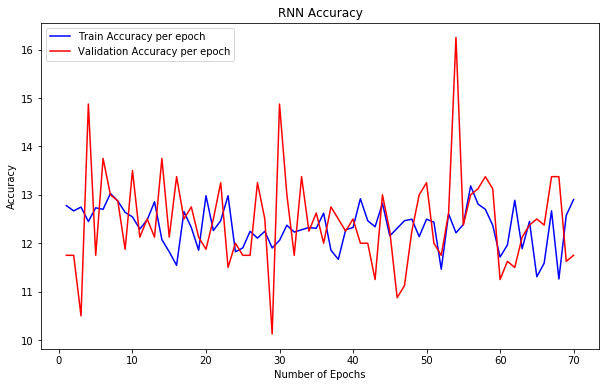

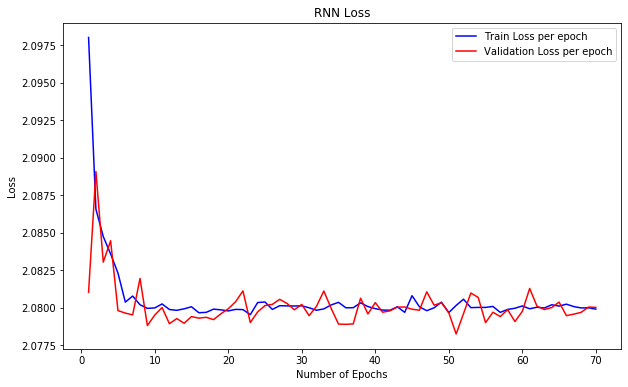

Test accuracy:  11.125


In [ ]:
epochs = 70
net_rnn = RNN().cuda()
optimizer = torch.optim.Adam(net_rnn.parameters(),weight_decay=0.01)
train_accuracy_rnn, valid_accuracy_rnn, train_loss_rnn, valid_loss_rnn = train(net_rnn,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_rnn,valid_accuracy_rnn,epochs,"RNN")
plot_loss(train_loss_rnn, valid_loss_rnn, epochs, "RNN")
test_accuracy_rnn = calc_test_accuracy(net_rnn)
print("Test accuracy: ", test_accuracy_rnn)

Epoch # 0
Train Accuracy = 29.15233030966531
Valid Accuracy = 37.5
Train Loss = 1.8760982221364975
Valid Loss = 1.7584519815444946
Epoch # 1
Train Accuracy = 36.143259305599
Valid Accuracy = 39.875
Train Loss = 1.7343204671144485
Valid Loss = 1.6423648834228515
Epoch # 2
Train Accuracy = 40.569283703472
Valid Accuracy = 43.5
Train Loss = 1.6435627591609956
Valid Loss = 1.666958532333374
Epoch # 3
Train Accuracy = 42.33656553018455
Valid Accuracy = 50.5
Train Loss = 1.6162633693218231
Valid Loss = 1.5646692752838134
Epoch # 4
Train Accuracy = 44.135126681263685
Valid Accuracy = 47.25
Train Loss = 1.568979400396347
Valid Loss = 1.5761700963974
Epoch # 5
Train Accuracy = 45.855489521426335
Valid Accuracy = 48.875
Train Loss = 1.5310518929362298
Valid Loss = 1.508931131362915
Epoch # 6
Train Accuracy = 47.0128245229903
Valid Accuracy = 46.625
Train Loss = 1.5137915074825288
Valid Loss = 1.5869790697097779
Epoch # 7
Train Accuracy = 47.5445730372224
Valid Accuracy = 45.0
Train Loss = 1.4942

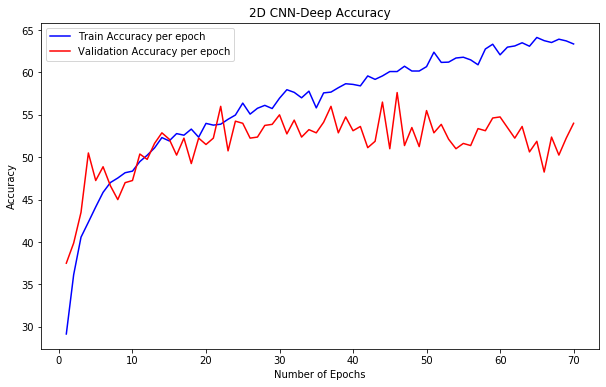

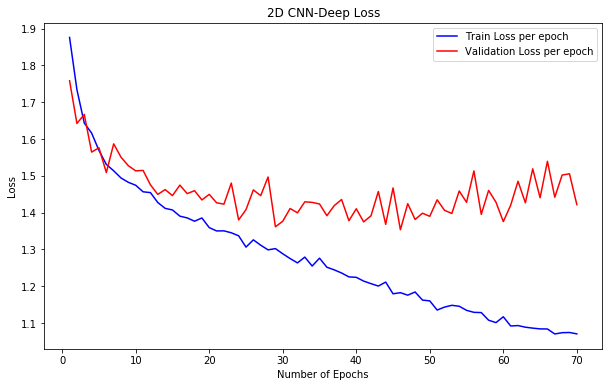

Test accuracy:  40.375


In [ ]:
epochs = 70
net_cnn_2d_deep = CNN_2D_Deep().cuda()
optimizer = torch.optim.Adam(net_cnn_2d_deep.parameters(),weight_decay=0.01)
train_accuracy_2d_deep, valid_accuracy_2d_deep, train_loss_2d_deep, valid_loss_2d_deep = train(net_cnn_2d_deep,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_2d_deep,valid_accuracy_2d_deep,epochs,"2D CNN-Deep")
plot_loss(train_loss_2d_deep, valid_loss_2d_deep, epochs, "2D CNN-Deep")
test_accuracy_2d_deep = calc_test_accuracy(net_cnn_2d_deep)
print("Test accuracy: ", test_accuracy_2d_deep)

Epoch # 0
Train Accuracy = 31.654676258992804
Valid Accuracy = 35.125
Train Loss = 1.8195014011859894
Valid Loss = 1.7538940191268921
Epoch # 1
Train Accuracy = 39.28683140444166
Valid Accuracy = 41.125
Train Loss = 1.6537211871147155
Valid Loss = 1.6069148874282837
Epoch # 2
Train Accuracy = 42.758836409133565
Valid Accuracy = 43.5
Train Loss = 1.5766329568624498
Valid Loss = 1.5631998348236085
Epoch # 3
Train Accuracy = 45.08914607444479
Valid Accuracy = 48.875
Train Loss = 1.528760256767273
Valid Loss = 1.4957845306396484
Epoch # 4
Train Accuracy = 46.62183296840788
Valid Accuracy = 49.125
Train Loss = 1.503468628525734
Valid Loss = 1.468125476837158
Epoch # 5
Train Accuracy = 47.79480763215515
Valid Accuracy = 45.875
Train Loss = 1.4729834389686585
Valid Loss = 1.5016724157333374
Epoch # 6
Train Accuracy = 48.87394432280263
Valid Accuracy = 48.0
Train Loss = 1.439123187661171
Valid Loss = 1.4695663452148438
Epoch # 7
Train Accuracy = 49.530810134501095
Valid Accuracy = 49.375
Train

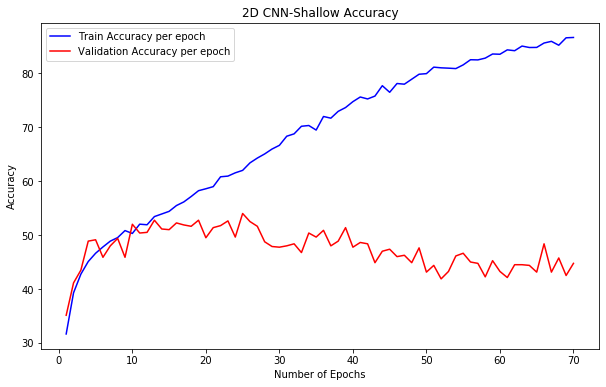

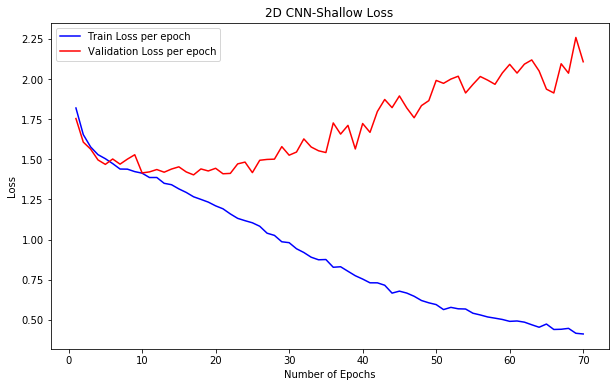

Test accuracy:  31.5


In [ ]:
epochs = 70
net_cnn_2d_shallow = CNN_2D_Shallow().cuda()
optimizer = torch.optim.Adam(net_cnn_2d_shallow.parameters(),weight_decay=0.01)
train_accuracy_per_epoch_2d_shallow, valid_accuracy_per_epoch_2d_shallow, train_loss_2d_shallow, valid_loss_2d_shallow = train(net_cnn_2d_shallow,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_per_epoch_2d_shallow,valid_accuracy_per_epoch_2d_shallow,epochs,"2D CNN-Shallow")
plot_loss(train_loss_2d_shallow, valid_loss_2d_shallow, epochs, "2D CNN-Shallow")
test_accuracy_2d_shallow = calc_test_accuracy(net_cnn_2d_shallow)
print("Test accuracy: ", test_accuracy_2d_shallow)

Epoch # 0
Train Accuracy = 29.918673756646857
Valid Accuracy = 38.5
Train Loss = 1.8195237171649934
Valid Loss = 1.6719623041152953
Epoch # 1
Train Accuracy = 39.05223647169221
Valid Accuracy = 40.125
Train Loss = 1.6478660893440247
Valid Loss = 1.6330195331573487
Epoch # 2
Train Accuracy = 43.13418830153269
Valid Accuracy = 44.625
Train Loss = 1.5904286420345306
Valid Loss = 1.569496874809265
Epoch # 3
Train Accuracy = 43.77541445104786
Valid Accuracy = 42.5
Train Loss = 1.567538744211197
Valid Loss = 1.5451992416381837
Epoch # 4
Train Accuracy = 45.073506412261494
Valid Accuracy = 46.75
Train Loss = 1.5335226601362228
Valid Loss = 1.5168287181854248
Epoch # 5
Train Accuracy = 47.184860807006565
Valid Accuracy = 49.625
Train Loss = 1.4892945659160615
Valid Loss = 1.486042356491089
Epoch # 6
Train Accuracy = 47.23177979355646
Valid Accuracy = 48.5
Train Loss = 1.4747293102741241
Valid Loss = 1.5375769186019896
Epoch # 7
Train Accuracy = 48.404754457303724
Valid Accuracy = 48.625
Train 

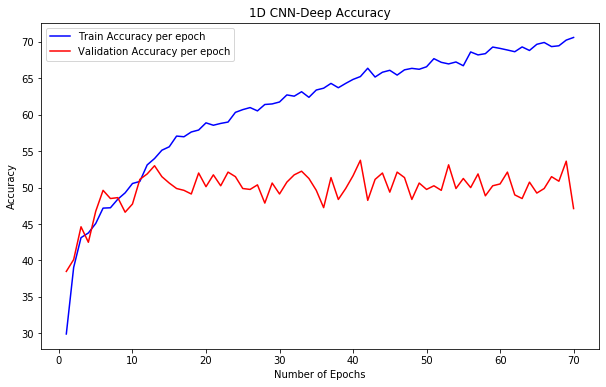

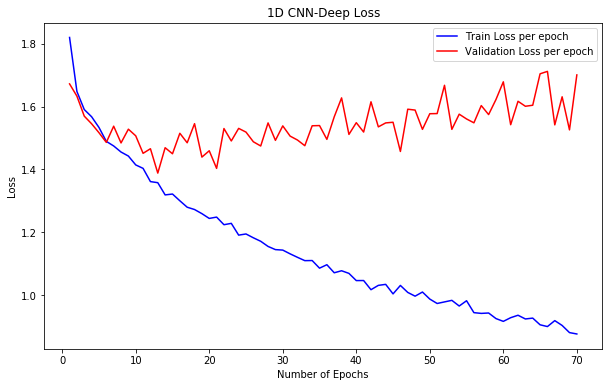

Test accuracy:  33.125


In [ ]:
epochs = 70
net_cnn_1d_deep = CNN_1D_Deep().cuda()
optimizer = torch.optim.Adam(net_cnn_1d_deep.parameters(),weight_decay=0.01)
train_accuracy_per_epoch_1d_deep, valid_accuracy_per_epoch_1d_deep, train_loss_1d_deep, valid_loss_1d_deep  = train(net_cnn_1d_deep,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_per_epoch_1d_deep,valid_accuracy_per_epoch_1d_deep,epochs,"1D CNN-Deep")
plot_loss(train_loss_1d_deep, valid_loss_1d_deep, epochs, "1D CNN-Deep")
test_accuracy_1d_deep = calc_test_accuracy(net_cnn_1d_deep)
print("Test accuracy: ", test_accuracy_1d_deep)

Epoch # 0
Train Accuracy = 21.567094150766344
Valid Accuracy = 20.625
Train Loss = 2.4078990799188613
Valid Loss = 2.0357896280288696
Epoch # 1
Train Accuracy = 25.28933375039099
Valid Accuracy = 23.125
Train Loss = 1.9248912620544434
Valid Loss = 1.9583972358703614
Epoch # 2
Train Accuracy = 26.994056928370348
Valid Accuracy = 23.125
Train Loss = 1.9137018322944641
Valid Loss = 1.949570746421814
Epoch # 3
Train Accuracy = 28.198310916484203
Valid Accuracy = 30.0
Train Loss = 1.8768904900550842
Valid Loss = 1.8933915662765504
Epoch # 4
Train Accuracy = 31.341883015326868
Valid Accuracy = 32.25
Train Loss = 1.8098538362979888
Valid Loss = 1.7840623807907106
Epoch # 5
Train Accuracy = 32.499218016890836
Valid Accuracy = 35.625
Train Loss = 1.7821377670764924
Valid Loss = 1.8286171913146974
Epoch # 6
Train Accuracy = 34.40725680325305
Valid Accuracy = 36.75
Train Loss = 1.7436901247501373
Valid Loss = 1.7241625452041627
Epoch # 7
Train Accuracy = 37.34751329371286
Valid Accuracy = 37.875


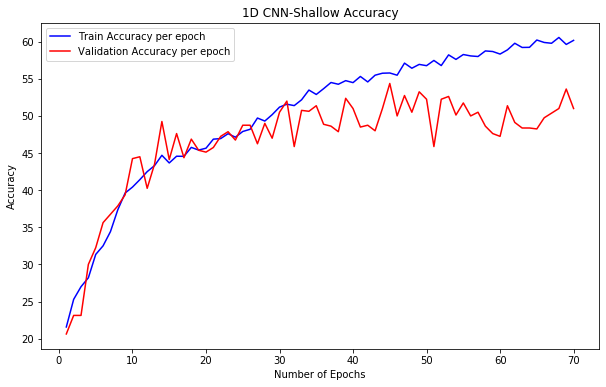

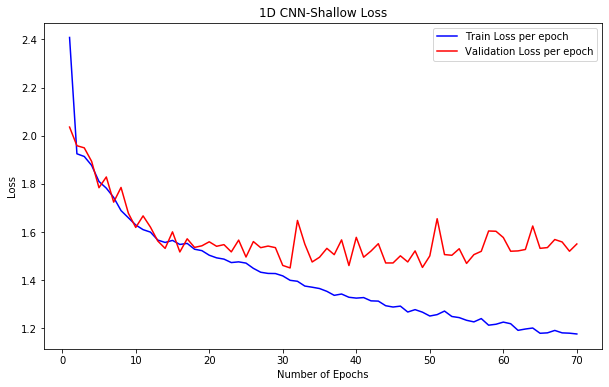

Test accuracy:  33.125


In [ ]:
epochs = 70
net_cnn_1d_shallow= CNN_1D_Shallow().cuda()
optimizer = torch.optim.Adam(net_cnn_1d_shallow.parameters(),weight_decay=0.01)
train_accuracy_per_epoch_1d_shallow, valid_accuracy_per_epoch_1d_shallow, train_loss_1d_shallow, valid_loss_1d_shallow  = train(net_cnn_1d_shallow,train_dataloader, epochs, optimizer)
plot_accuracies(train_accuracy_per_epoch_1d_shallow,valid_accuracy_per_epoch_1d_shallow,epochs,"1D CNN-Shallow")
plot_loss(train_loss_1d_shallow, valid_loss_1d_shallow, epochs, "1D CNN-Shallow")
test_accuracy_1d_shallow = calc_test_accuracy(net_cnn_1d_shallow)
print("Test accuracy: ", test_accuracy_1d_shallow)